# Measuring scintillation arcs with sctintools
In this notebook we will measure some scintillation arcs for PSR J0437-4715 to reproduce the method in Reardon et al. (2019).

## Import modules and load data
First, we import some modules and set the path for our input dynamic spectra

In [6]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import glob
sys.path.insert(0,'/Users/dreardon/Dropbox/git/scintools/scintools/')
from dynspec import Dynspec, MatlabDyn
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

data_dir = "./J0437-4715"
dyn_files = sorted(glob.glob(data_dir + '/*.dynspec'))

Now let's load and look at the first dynamic spectrum

LOADING ./J0437-4715/p111220_074112.rf.pcm.dynspec...
...LOADED in 0.41 seconds

	 OBSERVATION PROPERTIES

filename:			p111220_074112.rf.pcm.dynspec
MJD:				55915.3202776492
Centre frequency (MHz):		1382.0
Bandwidth (MHz):		400.0
Channel bandwidth (MHz):	0.78125
Integration time (s):		3904.0
Subintegration time (s):	32.0


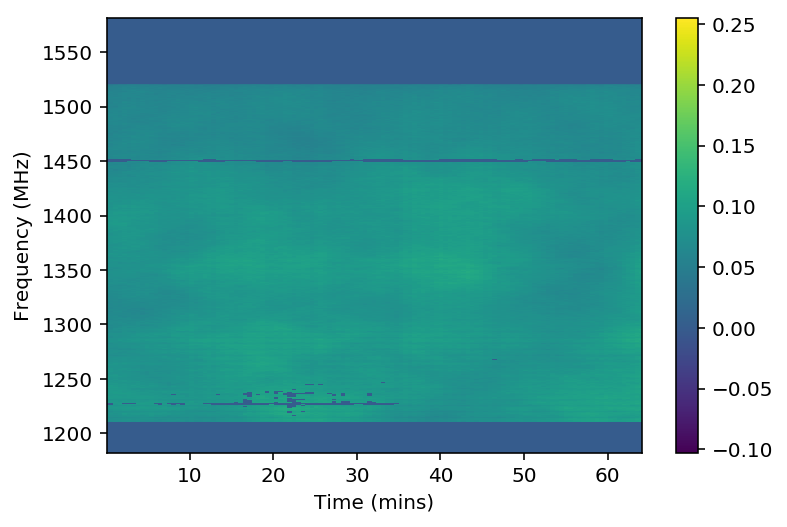

In [7]:
dyn = Dynspec(filename=dyn_files[0], process=False)  # loads the first dynamic spectrum, without processing
dyn.plot_dyn()  # plot the dynamic spectrum

Clearly the dynamic spectrum could use a bit of cleaning up!

## Processing dynamic spectra
The default processing can be accessed with the "process=True" option (True by default) for the Dynspec class, or can be done after initialisation with:

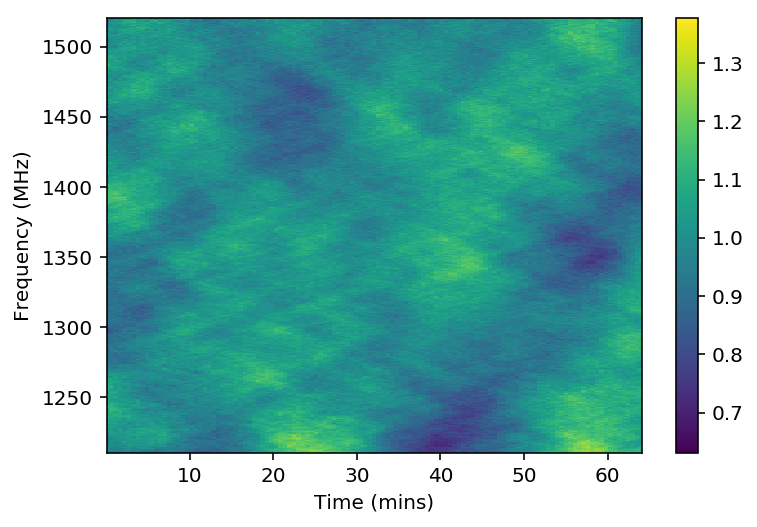

In [8]:
dyn.default_processing()
dyn.plot_dyn()

This processing command executes the following:
    1. dyn.trim_edges()  # to cut off the leading and trailing zeros on the band edges
    2. dyn.refill()  # to refills gaps (from e.g. rfi excision) with linear interpolation
    3. dyn.correct_band(time=True)  # to remove the bandpass and remove gain variations with time.
    4. dyn.calc_acf()  # to calculate the autocovariance function
    5. dyn.calc_sspec()  # to calculate the secondary spectrum
    
Therefore, we can now view the secondary spectrum!

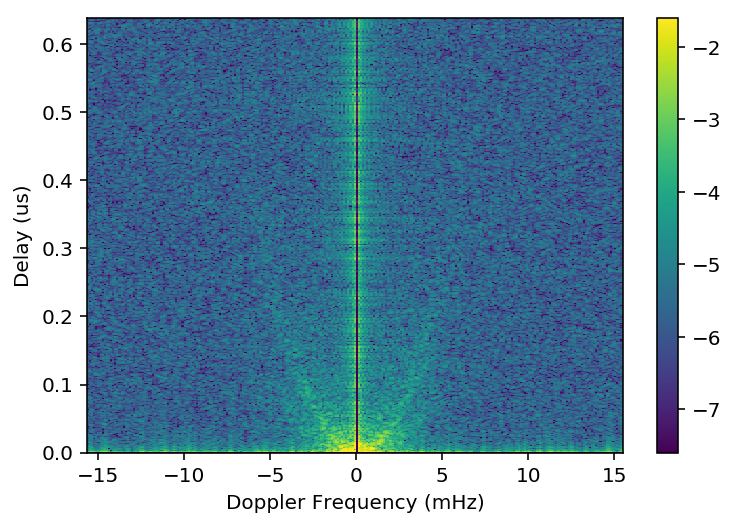

In [9]:
dyn.plot_sspec()

## Fitting arcs

Scintillations arcs are actually sharper when the dynamic spectrum is sampled in equal wavelength steps, rather than the traditional frequency steps. Therefore we re-sample the dynamic spectrum in equal "lamsteps" (for "lambda steps"). The scale_dyn() method will do this rescaling by default, and can be accessed from the initialisation of a Dynspec object with the optional flag "lamsteps=True"

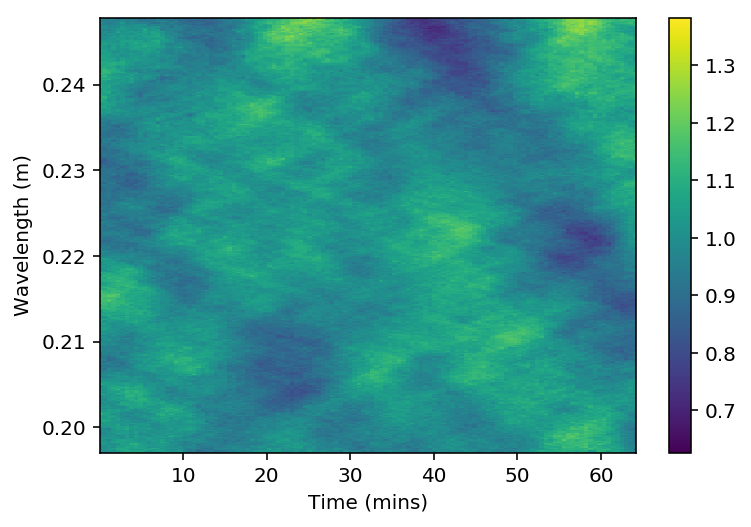

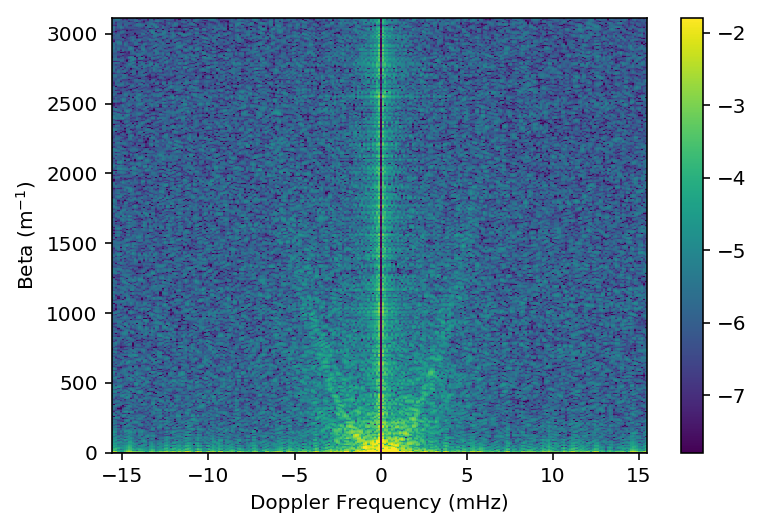

In [10]:
dyn.scale_dyn()
dyn.plot_dyn(lamsteps=True)
dyn.plot_sspec(lamsteps=True)

After resampling, the arc is sharpened slightly and the secondary arc becomes clearer! Now we can fit this arc, and plot the result with:

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


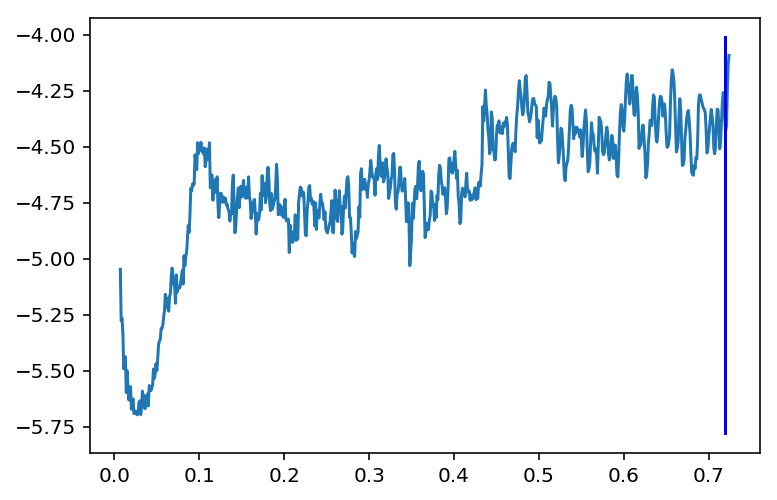

Currently takes curvature measurement as maximum -- update


In [14]:
dyn.fit_arc(plot=True)